In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import emcee
import pdb

In [3]:
fluxes = pd.read_csv('../data/fluxes.txt', delim_whitespace=True)

In [8]:
fluxes = fluxes.sort_values('S1400', ascending=False)
y_obs = fluxes['S1400'] # mJy
log_y_obs = np.log10(y_obs)
Lum_obs = 5.5 ** 2 * y_obs # mJy * kpc^2
log_Lum_obs = np.log10(Lum_obs) 
y_err = fluxes['err']
Lum_err = y_err # mJy * kpc^2
# log_Lum_err = np.log10(Lum_obs) 
Smin_obs = y_obs.min()
n = len(fluxes)
Sdiff_obs = 5.2

In [9]:
mu = -1.9
sig = .7
Smin = 0.015
N = 120

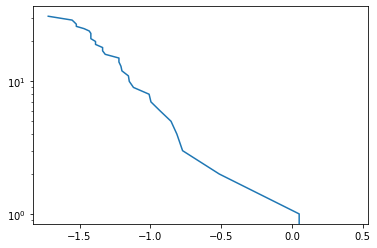

In [10]:
plt.semilogy(log_y_obs, np.arange(n))

In [11]:
from scipy.special import erfc, comb

In [12]:
def calc_pobs(Smin, mu, sig):
    return min(0.5 * erfc((np.log10(Smin) - mu) / (np.sqrt(2) * sig)), 1 - 1e-15)


In [13]:
def exception_handler(func):
    def inner_function(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except:
            pdb.set_trace()
    return inner_function

In [49]:
pmu.pdf(1)

0.0

In [51]:
def logL_obs(params, log_y_obs):
    mu, sig, Smin, N = params
    pobs = calc_pobs(Smin, mu, sig)
    n = len(log_y_obs)
    return np.log((1 / (pobs * sig * np.sqrt(2)*np.pi)))* n + np.sum(-(log_y_obs - mu) **2 / (2 * sig ** 2))

def logL_N(params):
    mu, sig, Smin, N = params
    pobs = calc_pobs(Smin, mu, sig)
    n = len(log_y_obs)
    return np.log(comb(N, n)) + n * np.log(pobs) + (N-n) * np.log(1 - pobs) 

def logL_diff(params):
    mu, sig, Smin, N = params
    Sexp = 10 ** (mu + 0.5 * sig ** 2 * np.log(10))
    Sdiff = N * Sexp
    sigdiff = np.sqrt(N) * Sexp * np.sqrt(10 ** (sig ** 2 * np.log(10)) - 1)
    return np.log(1 / (sigdiff * np.sqrt(2 * np.pi))) + (-(Sdiff_obs - Sdiff) ** 2 / (2 * sigdiff ** 2))

def logL(params, log_y_obs, cov):
    mu, sig, Smin, N = params
    prior = pmu.pdf(mu) * psig.pdf(sig) * pSmin.pdf(Smin) * pN.pdf(N)
    # prior = (1 / 3) * (1 / 1.4) * (1 / Smin_obs) * (1 / (500 - len(log_y_obs)))
    return logL_obs(params, log_y_obs) * logL_N(params) * logL_diff(params) * prior
    
# def log_prob(params, mean, cov):
#     return np.log(norm.)

In [15]:
from scipy.stats import norm, uniform

In [16]:
pmu = uniform(-2.5, 3)
psig = uniform(0.2, 1.4)
pSmin = uniform(0.000001, Smin_obs)
pN = uniform(n, 500 - n)
pr = norm(5.5, 0.9)

In [17]:
def get_init(nwalkers=10, seed=0):
    np.random.seed(seed)
    init = [pmu.rvs(nwalkers), psig.rvs(nwalkers), pSmin.rvs(nwalkers), np.array([int(x) for x in pN.rvs(nwalkers)])]
    return np.transpose(np.array(init))


In [41]:
import emcee
ndim = 4
nwalkers = 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, logL, args=[log_y_obs, cov])

In [52]:
p0 = get_init(nwalkers=nwalkers)

In [53]:
logL(p0[0], log_y_obs, cov)

-2602.5913289891423

In [54]:
sampler.run_mcmc(p0, 10)
# sampler.reset()

<ipython-input-12-50c851433673>:2: RuntimeWarning: invalid value encountered in log10
  return min(0.5 * erfc((np.log10(Smin) - mu) / (np.sqrt(2) * sig)), 1 - 1e-15)
<ipython-input-51-4be77b63f744>:5: RuntimeWarning: invalid value encountered in log
  return np.log((1 / (pobs * sig * np.sqrt(2)*np.pi)))* n + np.sum(-(log_y_obs - mu) **2 / (2 * sig ** 2))


ValueError: Probability function returned NaN

In [44]:
sampler.chain

AttributeError: you must run the sampler with 'store == True' before accessing the results

In [226]:
print(logL_diff(p0[66]))
print(logL_obs(p0[66], log_y_obs))
print(logL_N(p0[66]))

-642.0988613726574
-2738.730291707896
-inf


<ipython-input-179-7839d57d0868>:11: RuntimeWarning: divide by zero encountered in log
  return np.log(comb(N, n)) + n * np.log(pobs) + (N-n) * np.log(1 - pobs)


In [28]:
ptest = get_init(1000)

In [30]:
for ii in range(len(ptest)):
    
    print(logL(ptest[ii], log_y_obs, cov))

-2435.236513142134
-43902714.99224571
-11889.382063924459
-10445.772213537386
-957999.577688317
-2114.9194720074534
-4551.798994106694
-977406.4592901415
-210663.83805499467
-4494.085891711417
-2132.282665659417
-506106.45045660675
-17796.056513221647
-55068.41065017032
-89688804.46757796
-20.157427217206024
-106.05073440428936
-740573.3213743106
-14709.604691246694
-6916.991796765113
-4300908.509325113
-12235.151056812585
-4999.4691470360785
-14750.451183058722
-1074.7278904489424
-15718.675848587036
-65.49179139812296
-128903.08422511014
-7960.76700221603
-288645.7304886257
-822.3264179915794
-9155656.803598246
-2035.550464049175
-3266.525582967769
-12.88780828790858
-18456.174324504445
-6659.791871381141
-980.7247698631542
-1463949.6603970395
-13065.206419264436
-35115.07235870427
-9984.921539605934
-15249.931925795305
-71.49672639271512
-3849212.31401924
-10452.000669350273
-536.2191760134615
-1059.920071090005
-97.90946844430731
-6283.529381809742
-5880.842969225332
-1915943.25123

-991.0562126399717
-324437.00626314967
-112.71652131190837
-1708.78054465494
-148180.41934452436
-21.85459795431666
-188.14744401012922
-7249.252236752865
-1049.6920644711488
-2253.6721207922233
-497915.311348301
-83.94774352123233
-7230.456126846549
-51732.69019485077
-164224.5514855964
-8661.39109746732
-1759.9927943400965
-12049.148966620787
-9250.216728693136
-7837.2975999160535
-654.4479878566841
-7661.6849184607145
-303.372628970609
-3793.9221477268347
-1203.7692565246077
-394614.17421344225
-936.0349013734242
-22535.106188812
-6943.456918138783
-848.4917893298862
-37475.049689135194
-6296.724233216614
-122.47556587826176
-115186927.8250584
-41660.71888521163
-3918.5784344070476
-27457.234856119576
-3097456.9896394666
-1703964.2166272947
-21884.974279847494
-137056.0253680927
-35305.34081225842
-39.963207770728864
-342.8280784343469
-4259.693805779519
-3846281.3195290607
-2353710.613334257
-908.1255958455021
-26838.038597970837
-517.9388543499133
-11084.950241558456
-2000.3644876

In [165]:
for ii in range(len(p0)):
    
    print(logL(p0[ii], log_y_obs))

--Return--
None
> <ipython-input-159-f8f9f18ba40e>(6)inner_function()
      3         try:
      4             func(*args, **kwargs)
      5         except:
----> 6             pdb.set_trace()
      7     return inner_function

ipdb> p0
array([[-8.53559488e-01,  1.30841505e+00,  1.85947485e-02,
         1.55000000e+02],
       [-3.54431901e-01,  9.40452888e-01,  1.51850127e-02,
         3.94000000e+02],
       [-6.91709872e-01,  9.95262386e-01,  8.76910788e-03,
         2.45000000e+02],
       [-8.65350451e-01,  1.49583529e+00,  1.48310543e-02,
         2.98000000e+02],
       [-1.22903560e+00,  2.99450481e-01,  2.24821409e-03,
         4.00000000e+01],
       [-5.62317661e-01,  3.21981020e-01,  1.21594994e-02,
         3.21000000e+02],
       [-1.18723837e+00,  2.28305756e-01,  2.72471246e-03,
         3.18000000e+02],
       [ 1.75319002e-01,  1.36566778e+00,  1.79497094e-02,
         3.20000000e+02],
       [ 3.90988282e-01,  1.28941945e+00,  9.91611811e-03,
         4.73000000e+02]

BdbQuit: 

In [105]:
logL_obs(params, log_y_obs) * logL_N(params) * logL_diff(params) 

-1169.146378987846